# Analyse BlueSeis BSPF Event Analysis - Polarization

With pressure sensor parascientific and new sensor 

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
from functions.request_data import __request_data

In [3]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)

## Configurations

In [4]:
workdir = "/home/andbro/Documents/ROMY/BSPF"

In [5]:
config = {}

## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*"
# config['seed_seismometer'] = "PY.BSPF..HH*"

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

config['fmin'], config['fmax'] = 0.1, 15

## Load Data

In [6]:
# from functions.request_data import __request_data

In [7]:
st = obs.read("./event42_6c.mseed")

In [8]:
st = st.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

## S-Transform

In [9]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

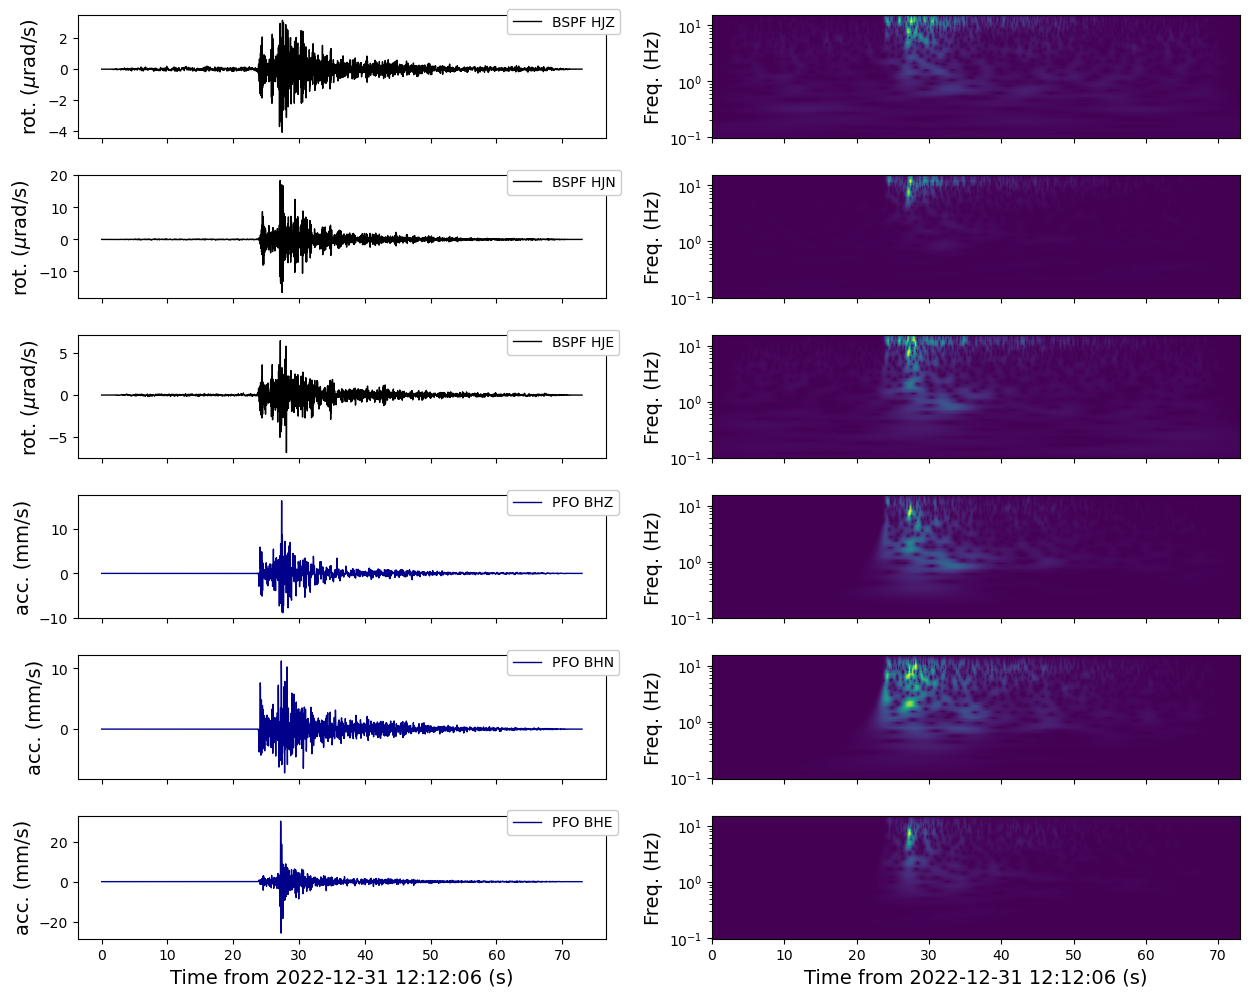

In [10]:
fig = __makeplotStream_cwt(st, config);

In [11]:
acc = st.select(station="PFO*").copy()
rot = st.select(station="BSPF").copy()

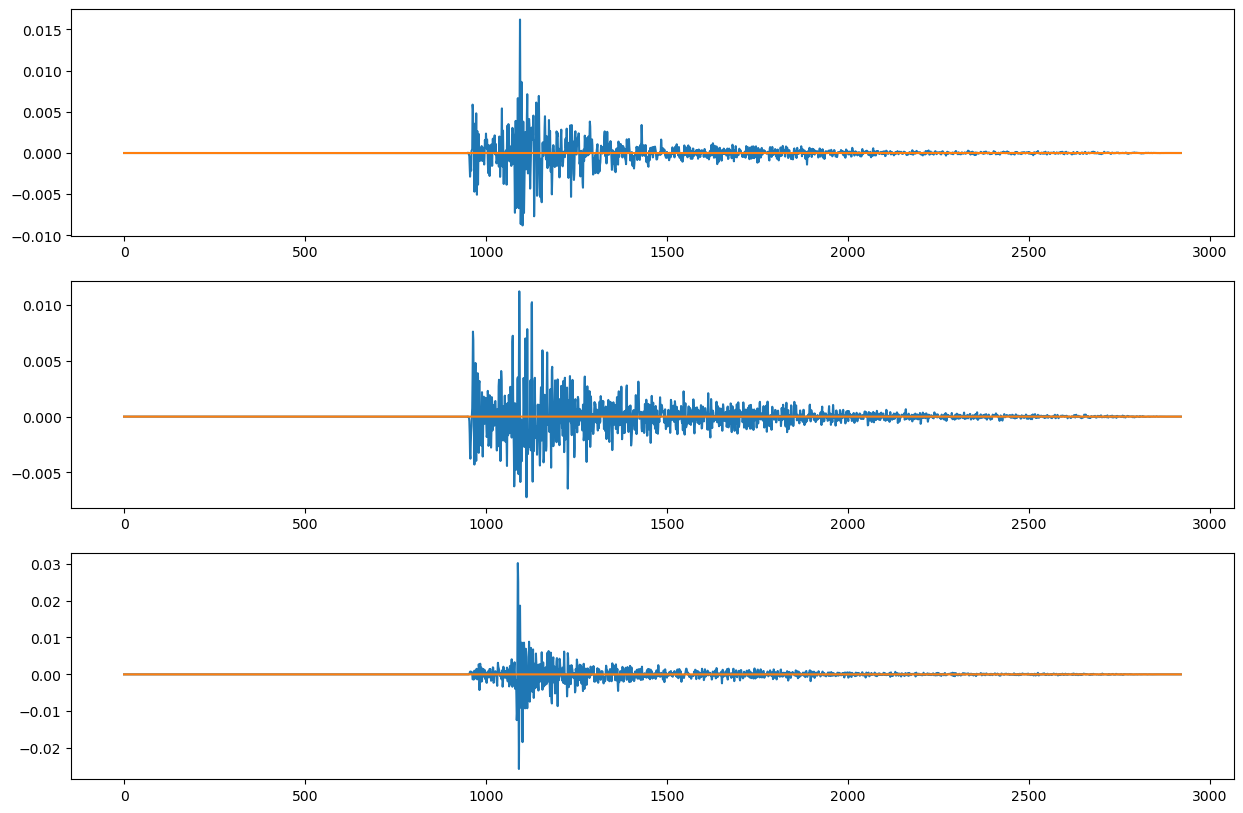

In [12]:
%matplotlib inline
fig, ax = plt.subplots(3,1, figsize=(15,10))

scaling_velocity = 1000

for i, c in enumerate(["Z","N","E"]):
    
    ax[i].plot(acc.select(channel=f"*{c}")[0].data)
    ax[i].plot(rot.select(channel=f"*{c}")[0].data/scaling_velocity)
    
plt.show();

## Frequency Domain

In [13]:
from twistpy.polarization import TimeFrequencyAnalysis6C, EstimatorConfiguration

In [14]:
for tr1, tr2 in zip(acc, rot):
    tr1.taper(0.1).detrend("linear")
    tr2.taper(0.1).detrend("linear")
    
for tr in acc: 
    tr.data /= scaling_velocity

window = {"number_of_periods": 2, "frequency_extent": 0.01}

# acc.plot(); rot.plot();

In [15]:
analysis = TimeFrequencyAnalysis6C(
                                    traN=acc.select(channel="*N")[0],
                                    traE=acc.select(channel="*E")[0],
                                    traZ=acc.select(channel="*Z")[0],
                                    rotN=rot.select(channel="*N")[0],
                                    rotE=rot.select(channel="*E")[0],
                                    rotZ=rot.select(channel="*Z")[0],
                                    window=window,
                                    dsfacf=100,
                                    dsfact=1,
                                    frange=[0.1, 15.0],
                                    scaling_velocity=scaling_velocity,
)

Computing covariance matrices...
Covariance matrices computed!


In [16]:
est = EstimatorConfiguration(
                            wave_types=["R","L"],
                            method="DOT",
                            scaling_velocity=scaling_velocity,
                            use_ml_classification=False,
                            vr=[0, 2000, 100],
                            xi=[-90, 90, 5],
                            phi=[0, 360, 20],
                            eigenvector=0,

)

In [ ]:
analysis.polarization_analysis(estimator_configuration=est)

Computing wave parameters...
Estimating wave parameters for R-Waves...


/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/polarization/model.py:340: RuntimeWarning: divide by zero encountered in true_divide
  w_x = 1.0 / self.vr * np.sin(phi_rad) * np.cos(xi_rad)
/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/polarization/model.py:340: RuntimeWarning: invalid value encountered in multiply
  w_x = 1.0 / self.vr * np.sin(phi_rad) * np.cos(xi_rad)
/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/polarization/model.py:341: RuntimeWarning: divide by zero encountered in true_divide
  w_y = -1.0 / self.vr * np.cos(phi_rad) * np.cos(xi_rad)
/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/numpy/linalg/linalg.py:2560: RuntimeWarning: invalid value encountered in multiply
  s = (x.conj() * x).real
/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/polarization/model.py:365: RuntimeWarning: invalid value encountered in true_divide
  polarization = np.divide(polarization, np.linalg.norm(polarization, axis=0))


In [ ]:
%matplotlib inline

In [ ]:
analysis.plot_wave_parameters(estimator_configuration=est, lh_min=0.2, lh_max=1.0)

## Polarization Analysis

In [ ]:
dt = py_bspf[0].stats.delta

scaling_velocity = 4000.0 # m/s

### Train Model

In [ ]:
svm = SupportVectorMachine(name="love_wave_test2")

########################################################################################################################
# Now we can train the model. For details, please check the example on how to train a
# 'twistpy.machinelearning.SupportVectorMachine' object. In short, we want to train the model for wave parameters
# that are typical for the near surface, and we want to be able to identify P, SV, SH and Rayleigh waves. This means
# that we do not make a distinction between Love and SH waves here, and Love waves will simply be contained in the SH
# wave class as the special case of horizontally propagating SH waves. Additionally, we make use of a Noise class, for
# analysis windows with a random polarization. We allow waves to arrive from all directions (azimuth range [0 360]
# degrees and inclination range [0 90] degrees).

svm.train(
            wave_types=["R", "P", "SV", "L", "Noise"],
            N=5000,
            scaling_velocity=scaling_velocity,
            vp=(2000, 5000),
            vp_to_vs=(1.6, 2.0),
            vl=(100, 3000),
            vr=(100, 3000),
            phi=(0, 360),
            theta=(0, 90),
            xi=(-90, 90),
            free_surface=True,
            C=1,
            kernel="rbf",
)

In [ ]:
# !rm /home/brotzer/TwistPy/twistpy/SVC_models/love_wave_test2.pkl

## Prepare

In [ ]:
rot = py_bspf.copy().trim(config['tbeg'], config['tend']).taper(0.1)
acc = ii_pfo_acc.copy().trim(config['tbeg'], config['tend']).taper(0.1)

In [ ]:
acc.select(channel="*Z")[0].data *= -1
rot.select(channel="*Z")[0].data *= -1

In [ ]:
for tr in acc:
    tr.data /= scaling_velocity

In [ ]:
acc.plot();
rot.plot();

## Time Domain

In [ ]:
########################################################################################################################
# Now that we have trained the model, we can set up our analysis. We will perform 6C polarization analysis in the time
# domain and use a sliding time window that is 0.05 s long (50 samples) with an overlap between subsequent windows of
# 50%.

dt = py_bspf[0].stats.delta

window = {"window_length_seconds": 5 * dt, "overlap": 50}

analysis = TimeDomainAnalysis6C(
                                traN=acc.select(channel="*N")[0],
                                traE=acc.select(channel="*E")[0],
                                traZ=acc.select(channel="*Z")[0],
                                rotN=rot.select(channel="*N")[0],
                                rotE=rot.select(channel="*E")[0],
                                rotZ=rot.select(channel="*Z")[0],
                                window=window,
                                scaling_velocity=scaling_velocity,
)

In [ ]:
########################################################################################################################
# To classify the waves, we simply do (yielding a classification of the first eigenvector of the covariance matrix):

analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

#  Wave parameter estimation

# est = EstimatorConfiguration(
#                             wave_types=["L", "R"],
#                             method="DOT",
#                             scaling_velocity=scaling_velocity,
#                             use_ml_classification=False,
    
#                             svm=svm,
# )

est = EstimatorConfiguration(
                            wave_types=["R"],
                            method="DOT",
                            scaling_velocity=scaling_velocity,
                            use_ml_classification=False,
                            vr=[1000, 4500, 100],
                            xi=[-90, 90, 2],
                            phi=[0, 360, 10],
                            eigenvector=0,
                            svm=svm,
)


analysis.polarization_analysis(estimator_configuration=est)

analysis.plot(estimator_configuration=est, dop_clip=0.9)


## Test Example

In [ ]:
# data = obs.read("/home/andbro/Documents/ROMY/twistpy/TwistPy/example_data/ROMY_gulf_of_alaska_teleseism.mseed")

# # scaling_velocity = 4500.0

# for n, trace in enumerate(data):
#     trace.detrend("spline", order=5, dspline=100)
#     trace.trim(starttime=trace.stats.starttime, endtime=trace.stats.endtime - 4500)
#     trace.taper(0.2)
#     if n < 3:
#         trace.data /= scaling_velocity

# window = {"number_of_periods": 1, "frequency_extent": 0.01}

# analysis = TimeFrequencyAnalysis6C(
#     traN=data[0],
#     traE=data[1],
#     traZ=data[2],
#     rotN=data[3],
#     rotE=data[4],
#     rotZ=data[5],
#     window=window,
#     dsfacf=20,
#     dsfact=20,
#     frange=[0.01, 0.15],
# )

# est = EstimatorConfiguration(
#     wave_types=["R"],
#     method="DOT",
#     scaling_velocity=scaling_velocity,
#     use_ml_classification=False,
#     vr=[3000, 4000, 100],
#     xi=[-90, 90, 2],
#     phi=[150, 210, 1],
#     eigenvector=0,
# )

# analysis.plot_wave_parameters(estimator_configuration=est, lh_min=0.7, lh_max=1.0)
